In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
import time

# from labtools.adtools.counter import seq_counter

In [2]:
pwd

'/global/scratch/users/empchase/A10_sequencing/v2'

In [2]:
seqfile = 'Ciberv2_A10_1_sequences.txt'

a10design = 'a10_designfile.csv'


In [3]:
#get list of designed tiles

a10dt = []

with open(a10design, 'r') as f: #read in design file (just arrayDNA column)
    for line in f:
        if "ArrayDNA" in line:
            pass
        else:
            a10dt.append(line.strip())
# print(a10dt[:5])
print(len(a10dt))#20783

#create a dictionary of values
dtiles = {}
for i in a10dt:
    dtiles[i] = 1
    
# print(d)

20783


In [4]:
def complement(seqn):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N':'N', 'X':'X'} 
    bases = list(seqn) 
    bases = [complement[base] for base in bases] 
    return ''.join(bases)
def reverse_complement(s):
        return complement(s[::-1])

In [8]:
def getmid(seq, pre, post):
    """ 
        # seq = the sequence to parse
        # pre = substring that precedes piece of interest
        # post = substring that follows piece of interest
        # returns piece of interest
    """
    
    re_key = pre + "(.*)"+ post #the pattern that the re search will use
    poi_search = re.search(re_key, seq) #point of interest search: returns a re object, which can be split into groups
#     print(poi_search)
    if poi_search is None:
        poi = "X"
    else:
        poi = poi_search.group(1) #if poi search was successful, group(1) is the sequence between the up/down-stream in puts
    
    return poi


def tilebc_mapper(readfile, tile_pre = "GGCTA.C", tile_post = "TGAC.AGCTGAGG", 
                  adBC_pre = "GAGGCGCGCC", adBC_post = "GGGCCCCTT", 
                  rpBC_pre = "GCTCGAG", rpBC_post = "GGCC...CAT"):
    
    """ 
        #readfile = file of SEQUENCES ONLY
        # *_pre or *_post = the consensus sequences before or after each feature
    """

    
    readlist = [] # make lists of reads
    print('started function')
    total_iterations = 129306992 #this was specific to my file 'Ciberv2_A10_1_sequences.txt', used to calculate how many iterations to 10%
    
    with open(readfile, 'r') as fin: #open file
        
        iteration_count = 0 #start a counter for the loop to be able to print progress at N iterations
        
        start1 = time.perf_counter() #start "stopwatch"
        print("Opened file")
 
        for line in fin: #for each line
            iteration_count += 1 #count the iteration
            seq = line.strip() # clean the line
            seq = reverse_complement(seq) # return the reverse complement of the sequence in that line
            readlist.append(seq) # append that 5'->3' sequence to your list
            
            if iteration_count % 1000000000 ==0:
                print((f"Iteration {iteration_count}: Progress {iteration_count/total_iterations*100:.2f}%"))
                finish = time.perf_counter()
                print(f'finished opening in {round(finish-start1, 2)} seconds')
            
    finish = time.perf_counter()
    print(f'finished files in {round(finish-start1, 2)} seconds')        
    #make lists of tiles/BCs from list of reads
    tile_list = []
    tile_lengths= []    
    des_query = [] # tells us if tile matches design or not
    
    adBC_list = []
    adBC_lengths = []
    rpBC_list = []
    rpBC_lengths = []
    
    for i, read in enumerate(readlist): 
        """
        this loop goes read by read and adds in the above lists: 
        tiles/length/whether they're designed
        AD BC/length
        RPTR BC/length
        
        Each read occupies same index throughout the lists, therefore lists can be concatenated into df at the end
        """
        i += 1 #start a counter for the loop to be able to print progress at N iterations
        start2 = time.perf_counter() #start "stopwatch"
        
        tile = getmid(read, tile_pre, tile_post) #use consensus seq to find tile
        tile_list.append(tile) #add tile to list
        tile_len = len(tile) #find length of tile
        tile_lengths.append(tile_len) #add length to list
            
        if tile in dtiles: #check the dictionary of designed tiles
            des_query.append(1)
        else:
            des_query.append(0)
        
        adBC = getmid(read, adBC_pre, adBC_post) #find AD BC
        adBC_list.append(adBC)
        adBC_len = len(adBC) #and Length
        adBC_lengths.append(adBC_len)


        rpBC = getmid(read, rpBC_pre, rpBC_post) #find RPTR BC
        rpBC_list.append(rpBC)
        rpBC_len = len(rpBC) #and Length
        rpBC_lengths.append(rpBC_len)

        if i % 1000000 == 0: #status updates
            finish = time.perf_counter()
            print(i)
            print(f'finished 10th loop in {round(finish-start2, 2)} seconds')
            
    # make the df
    tileBC_dict = {"Tiles":tile_list, "T Len" : tile_lengths, "Designed": des_query, 
                  "AD BCs":adBC_list, "A Len": adBC_lengths,
                   "RPTR BCs":rpBC_list, "R Len": rpBC_lengths}
    tileBC_df = pd.DataFrame.from_dict(tileBC_dict)
    
    finish = time.perf_counter()
    print(f'finished everything in {round(finish-start1, 2)} seconds')
    
    return tileBC_df

### Output df has all reads from the seqfile

map1 is the original df

In [9]:
testmap = tilebc_mapper('tinierCiberv2seq.txt')

started function
Opened file
finished files in 0.0 seconds
finished everything in 0.0 seconds


In [10]:
testmap.head(15)

,Tiles,T Len,Designed,AD BCs,A Len,RPTR BCs,R Len
0,ACTTCTAACTTTCATCATGATCAAGAAGCTGACTTTGTCTTGTTTC...,119,0,X,1,CAGTTATCTCGTTA,14
1,AAAGCTACTGGTCCACCAGCATCTCCAGTTATTAGAGGTTCTGCTT...,120,0,X,1,X,1
2,GGTTCTGGTACTCCACAAAGGAAAGGTTCTGTTGCTTCTACTGGTC...,120,0,X,1,GAAGGAGCAGGTGC,14
3,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,120,1,X,1,AGAAGAACTGAGGA,14
4,TCTTGGTTGCCTTCTTCTTCTTCTTCTCCACCAGCTGCATCTGCTC...,120,0,X,1,GAAGGAAATATGAT,14
5,ATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTTCTCCAT...,120,1,X,1,AGACTATAGAAGTG,14
6,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,120,1,X,1,TAATCGGATACGTA,14
7,AATCAACAAGCTCCAGATGCTCAACCACATCCATCTTCTCCAGCTC...,101,0,TATTTTGGAAC,11,ACCTCCTCGCTCGC,14
8,X,1,0,X,1,ACGTTAAACTAAAC,14
9,X,1,0,X,1,TAAAAAAAAGAGGG,14


In [30]:
test2map = tilebc_mapper('tinyishCiberv2seq.txt')

started function
Opened file
finished opening in 0.0 seconds
Iteration 10: Progress 10.00%
Iteration 20: Progress 20.00%
Iteration 30: Progress 30.00%
Iteration 40: Progress 40.00%
Iteration 50: Progress 50.00%
Iteration 60: Progress 60.00%
Iteration 70: Progress 70.00%
Iteration 80: Progress 80.00%
Iteration 90: Progress 90.00%
Iteration 100: Progress 100.00%
finished files in 0.01 seconds
finished everything in 0.01 seconds


In [12]:
test2map.head()

,Tiles,T Len,Designed,AD BCs,A Len,RPTR BCs,R Len
0,ACTTCTAACTTTCATCATGATCAAGAAGCTGACTTTGTCTTGTTTC...,119,0,X,1,CAGTTATCTCGTTA,14
1,AAAGCTACTGGTCCACCAGCATCTCCAGTTATTAGAGGTTCTGCTT...,120,0,X,1,X,1
2,GGTTCTGGTACTCCACAAAGGAAAGGTTCTGTTGCTTCTACTGGTC...,120,0,X,1,GAAGGAGCAGGTGC,14
3,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,120,1,X,1,AGAAGAACTGAGGA,14
4,TCTTGGTTGCCTTCTTCTTCTTCTTCTCCACCAGCTGCATCTGCTC...,120,0,X,1,GAAGGAAATATGAT,14


In [11]:
test2map["AD BCs"].value_counts().to_frame().reset_index()

,index,AD BCs
0,X,82
1,TCGATCTCTCA,1
2,TAGGCTTAACA,1
3,CGGCCCTTTCC,1
4,AAGTTCAAAGC,1
5,TACCCGGGTTA,1
6,AGTGCCAACCG,1
7,GACGGATGGGT,1
8,GCCCTTCCTAT,1
9,ACTAGATTAAA,1


In [11]:
#load the library #129,306,992 reads
map1 = tilebc_mapper(seqfile)

started function
Opened file
finished files in 1913.69 seconds
1000000
finished 10th loop in 0.0 seconds
2000000
finished 10th loop in 0.0 seconds
3000000
finished 10th loop in 0.0 seconds
4000000
finished 10th loop in 0.0 seconds
5000000
finished 10th loop in 0.0 seconds
6000000
finished 10th loop in 0.0 seconds
7000000
finished 10th loop in 0.0 seconds
8000000
finished 10th loop in 0.0 seconds
9000000
finished 10th loop in 0.0 seconds
10000000
finished 10th loop in 0.0 seconds
11000000
finished 10th loop in 0.0 seconds
12000000
finished 10th loop in 0.0 seconds
13000000
finished 10th loop in 0.0 seconds
14000000
finished 10th loop in 0.0 seconds
15000000
finished 10th loop in 0.0 seconds
16000000
finished 10th loop in 0.0 seconds
17000000
finished 10th loop in 0.0 seconds
18000000
finished 10th loop in 0.0 seconds
19000000
finished 10th loop in 0.0 seconds
20000000
finished 10th loop in 0.0 seconds
21000000
finished 10th loop in 0.0 seconds
22000000
finished 10th loop in 0.0 seconds


In [12]:
map1.to_csv('A10_1_tbcRAW.csv')

### Analysis before filtering out bad tiles or barcodes

In [13]:
map1.describe()

,T Len,Designed,A Len,R Len
count,1.293070e+08,1.293070e+08,1.293070e+08,1.293070e+08
mean,5.817667e+01,2.759779e-01,2.716468e+00,9.403521e+00
std,5.858541e+01,4.470057e-01,3.772345e+00,6.337351e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
50%,1.000000e+00,0.000000e+00,1.000000e+00,1.400000e+01
75%,1.200000e+02,1.000000e+00,1.000000e+00,1.400000e+01
max,1.840000e+02,1.000000e+00,1.490000e+02,2.160000e+02


In [14]:
map1.head()

,Tiles,T Len,Designed,AD BCs,A Len,RPTR BCs,R Len
0,ACTTCTAACTTTCATCATGATCAAGAAGCTGACTTTGTCTTGTTTC...,119,0,X,1,CAGTTATCTCGTTA,14
1,AAAGCTACTGGTCCACCAGCATCTCCAGTTATTAGAGGTTCTGCTT...,120,0,X,1,X,1
2,GGTTCTGGTACTCCACAAAGGAAAGGTTCTGTTGCTTCTACTGGTC...,120,0,X,1,GAAGGAGCAGGTGC,14
3,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,120,1,X,1,AGAAGAACTGAGGA,14
4,TCTTGGTTGCCTTCTTCTTCTTCTTCTCCACCAGCTGCATCTGCTC...,120,0,X,1,GAAGGAAATATGAT,14


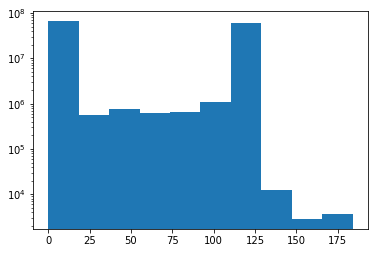

In [18]:
#plot tiles as histogram

# sns.histplot(data=map1, x='T Len')
plt.hist(map1['T Len'])
# plt.xlim([100, 125])
plt.yscale('log')
plt.show()

In [17]:
#look into specifics of who has what length...
map1[map1["T Len"] == 120].shape[0]

41971250

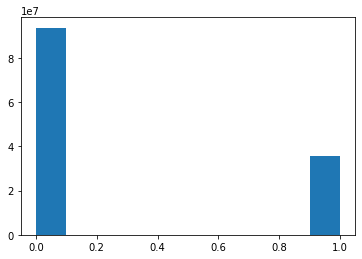

In [20]:
#plot tile qual as histogram

plt.hist(map1['Designed'])

plt.show()

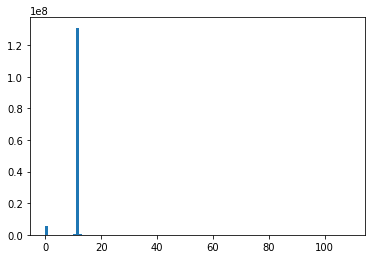

In [12]:
# # plot AD BC len

# plt.hist(map1['A Len'], bins=100)
# plt.show()

In [16]:
# #look into specifics of who has what length...
# map1[map1["A Qual"] == 1].shape[0]

131015599

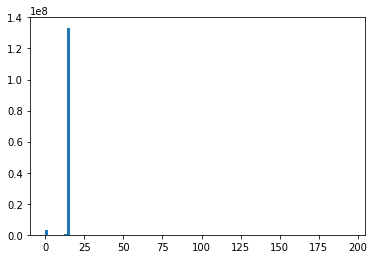

In [17]:
# # plot RPTR BC len

# plt.hist(map1['R Len'], bins=100)
# plt.show()

In [18]:
# #look into specifics of who has what length...
# map1[map1["R Qual"] == 1].shape[0]

133192330

In [19]:
# map1[map1["Designed"] == 1].shape[0]

81795027

In [20]:
# color_conditions = {
#     'Designed_Not120': (map1['Designed'] & ~map1['T Qual']),
#     'NotDesigned_Yes120': (~map1['Designed'] & map1['T Qual']),
#     'true_both': (map1['Designed'] & map1['T Qual']),
#     'false_both': (~map1['Designed'] & ~map1['T Qual'])
# }

In [21]:
# colors = {
#     'Designed_Not120': 'blue',
#     'NotDesigned_Yes120': 'orange',
#     'true_both': 'green',
#     'false_both': 'red'
# }

In [22]:
# color_counts = {category: condition.sum() for category, condition in color_conditions.items()}

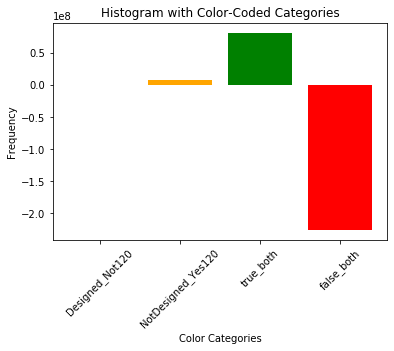

In [23]:
# plt.bar(color_counts.keys(), color_counts.values(), color=[colors[c] for c in color_counts.keys()])
# plt.xlabel('Color Categories')
# plt.ylabel('Frequency')
# plt.title('Histogram with Color-Coded Categories')
# plt.xticks(rotation=45)
# plt.show()

Observations from above: Most reads have a tile, and nearly all the reads have a legible barcode. Most of the tiles that are legible are also designed


Now we want to know:
1. Coverage? ie Each tile shows up how many times? -- look at tiles ==120 bp
2. How many of those tiles are designed?
3. Coverage of tile-bc-bc combos??

### Filtering out reads that either do not have the consensus sequences to find the tiles/BCs OR have tiles/BCs of unexpected lengths

map2 is the df with only tiles that match designed and where BC lengths are as expected. All length and quality columns are dropped, as well as the column that stored the full read strings.

In [2]:
A10map1 = pd.read_csv('A10_1_tbcRAW.csv')
A10map1.head()

,Unnamed: 0,Tiles,T Len,Designed,AD BCs,A Len,RPTR BCs,R Len
0,0,ACTTCTAACTTTCATCATGATCAAGAAGCTGACTTTGTCTTGTTTC...,119,0,X,1,CAGTTATCTCGTTA,14
1,1,AAAGCTACTGGTCCACCAGCATCTCCAGTTATTAGAGGTTCTGCTT...,120,0,X,1,X,1
2,2,GGTTCTGGTACTCCACAAAGGAAAGGTTCTGTTGCTTCTACTGGTC...,120,0,X,1,GAAGGAGCAGGTGC,14
3,3,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,120,1,X,1,AGAAGAACTGAGGA,14
4,4,TCTTGGTTGCCTTCTTCTTCTTCTTCTCCACCAGCTGCATCTGCTC...,120,0,X,1,GAAGGAAATATGAT,14


In [3]:

#Replace all 0s in map1 with NaN to filter out any Qual=0 reads
A10map1.replace('X', np.nan, inplace=True)
# map1_nans.head()
clabels = ['T Len', 'Designed', 'A Len', 'R Len'] #get rid of some now useless columns
map2 = A10map1.dropna().reset_index().drop(clabels, axis = 1)

map2.head()

NameError: name 'map1' is not defined

In [6]:
map2.drop(['index', 'Unnamed: 0'], axis=1, inplace=True)
map2.head()

,Tiles,AD BCs,RPTR BCs
0,AATCAACAAGCTCCAGATGCTCAACCACATCCATCTTCTCCAGCTC...,TATTTTGGAAC,ACCTCCTCGCTCGC
1,GGTAAATTGAAAGTTTGGATTAGAAGTGTTTGGACTTTGGAAATGT...,TGACACCGGCT,GAAGTTACGTGAGA
2,ATGATTGCCACCAATTAAATTTGATTCTGCTGATCCAGCTGCTATGAAA,GCCCTTCCTAT,CCTTGCCACCTTTC
3,CAATCTTTGCAAGGTGCTACTAATAAGATGGATATTCAAGATTTGG...,CCACGTGCCCA,AATAATGACCTGAT
4,TCTGAATCTCCATTTATTGATGATTTGTATGATACTTCTCCATGTT...,GTGAGTACATT,CCTACGACTGTATA


In [7]:
# how many reads are lost? rc = readcount
rcmap1 = A10map1.shape[0]
rcmap2 = map2.shape[0]
diffpct = ((rcmap1 - rcmap2) / rcmap1)*100
print("% Reads lost:")
print(diffpct)
print(rcmap2)

% Reads lost:
89.35027890835168
13770834


### Coverage
map3 is a df with tiles, BCs, and combos of tiles and BCs

In [8]:
map3 = map2.copy()
map3.head()

,Tiles,AD BCs,RPTR BCs
0,AATCAACAAGCTCCAGATGCTCAACCACATCCATCTTCTCCAGCTC...,TATTTTGGAAC,ACCTCCTCGCTCGC
1,GGTAAATTGAAAGTTTGGATTAGAAGTGTTTGGACTTTGGAAATGT...,TGACACCGGCT,GAAGTTACGTGAGA
2,ATGATTGCCACCAATTAAATTTGATTCTGCTGATCCAGCTGCTATGAAA,GCCCTTCCTAT,CCTTGCCACCTTTC
3,CAATCTTTGCAAGGTGCTACTAATAAGATGGATATTCAAGATTTGG...,CCACGTGCCCA,AATAATGACCTGAT
4,TCTGAATCTCCATTTATTGATGATTTGTATGATACTTCTCCATGTT...,GTGAGTACATT,CCTACGACTGTATA


In [9]:
adcol = map3['AD BCs'].copy()
rpcol = map3['RPTR BCs'].copy()

map3['Cat'] = map3['Tiles'].str.cat(adcol, sep="-").str.cat(rpcol, sep="-")
# map3['BC Pairs'] = map3['AD BCs'].str.cat(rpcol, sep='-')

map3.head()

,Tiles,AD BCs,RPTR BCs,Cat
0,AATCAACAAGCTCCAGATGCTCAACCACATCCATCTTCTCCAGCTC...,TATTTTGGAAC,ACCTCCTCGCTCGC,AATCAACAAGCTCCAGATGCTCAACCACATCCATCTTCTCCAGCTC...
1,GGTAAATTGAAAGTTTGGATTAGAAGTGTTTGGACTTTGGAAATGT...,TGACACCGGCT,GAAGTTACGTGAGA,GGTAAATTGAAAGTTTGGATTAGAAGTGTTTGGACTTTGGAAATGT...
2,ATGATTGCCACCAATTAAATTTGATTCTGCTGATCCAGCTGCTATGAAA,GCCCTTCCTAT,CCTTGCCACCTTTC,ATGATTGCCACCAATTAAATTTGATTCTGCTGATCCAGCTGCTATG...
3,CAATCTTTGCAAGGTGCTACTAATAAGATGGATATTCAAGATTTGG...,CCACGTGCCCA,AATAATGACCTGAT,CAATCTTTGCAAGGTGCTACTAATAAGATGGATATTCAAGATTTGG...
4,TCTGAATCTCCATTTATTGATGATTTGTATGATACTTCTCCATGTT...,GTGAGTACATT,CCTACGACTGTATA,TCTGAATCTCCATTTATTGATGATTTGTATGATACTTCTCCATGTT...


In [10]:
# Now make a df that tells me the frequency of each tile-bc-bc combo

tbbcov = map3['Cat'].value_counts().to_frame().reset_index()
print('number unique tbb combos:')
print(tbbcov.shape[0]) 
tbbcov.head(10)

number unique tbb combos:
2032406


,index,Cat
0,CCACAATCTGTTATCTT-CCCACCCGTGC-GCTGAGCTATTCAG,13983
1,CCATTGATAATTCTAGAATTGCTGTTCCATCTCAAAGAAGACATTC...,13486
2,GTTTCTCCATTTATTGGTGATAATCAAGATTTGGATCAAGCTTTGT...,8855
3,CAACAAACTCAACCATTGCCAGAATTGGTTCAACCAGTTCAACCAA...,3886
4,TTGGAAAGAAATGGTGCTAAGATTCAATTATAGAAGATGTTCTTTG...,2412
5,AATAATTTGCCATCTGATTGGTTGTGTTCTGGTAATGGTGGTAATA...,2262
6,TCTGAGAGCTAGGAAATTGGAAAGAATGAATCATTG-TCTCTGCGT...,2197
7,CCATTGCCACCAATTCTAGAGAATCTAGAGCTAGGAAATATGAACA...,2024
8,GATCAAGCTTTGTCTGGTGATCCATGGTATCCATTGTTTCCACAAG...,1995
9,GAAATTTCTGGTTGTGATTCTCATAAAATTCTTCTCCA-CTTGCCG...,1970


In [12]:
# plot tbb coverage on histogram

# plt.figure()
# plt.hist(tbbcov['Cat'],  bins=75)
# plt.xlabel('Coverage')
# plt.ylabel('Counts')
# plt.show()

sns.histplot(data=tbbcov, x='Cat', log_scale=(True, True))


AttributeError: module 'seaborn' has no attribute 'histplot'

In [29]:
tbbcov.describe()

,Cat
count,2.081431e+07
mean,3.770026e+00
std,3.329860e+00
min,1.000000e+00
25%,1.000000e+00
50%,3.000000e+00
75%,5.000000e+00
max,6.600000e+01


In [30]:
# Tile coverage
tcov = map2['Tiles'].value_counts().to_frame().reset_index()
print ('# unique Tiles:')
print(tcov.shape[0])
tcov.head()

# unique Tiles:
20643


,index,Tiles
0,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,15926
1,TTGCAACAGAAACATAGATTGGCTCAAATTCAAGCTTCTGGTTCTC...,10289
2,TCTGCTGATTATTCTGGTTTGCAATCTGATTATTCTCCATTGACTG...,10250
3,TCTATTGCTTCTAGATCTTCTTCTTCTTCTCCAAATAACTTTGCTC...,10161
4,GATGTTACTCCAGCTTCTCCAATGATTAGAACTACTTCTTCTAGAG...,9615


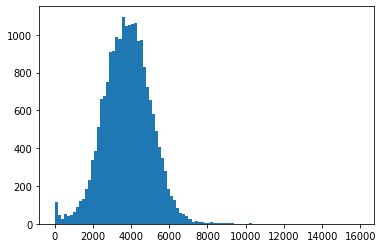

In [32]:
# plot tile coverage 
plt.hist(tcov['Tiles'], bins=100)
plt.show()

In [33]:
#ad bc coverage
abcov = map3['AD BCs'].value_counts().to_frame().reset_index()
print(abcov.shape) # number unique ad bcs:
abcov.head()

(4038576, 2)


,index,AD BCs
0,TCCCCCCCCCC,798
1,GCCCCCCCGCC,740
2,TCCCCCCCCTC,725
3,TCCCCCGCCCC,675
4,GCCCCCGCCCC,675


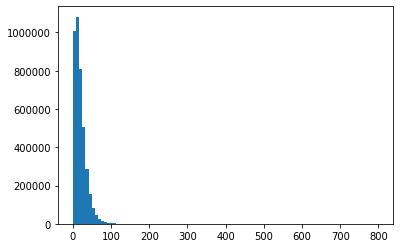

In [35]:
# plot ad bc coverage 
plt.hist(abcov['AD BCs'], bins=100)
plt.show()

In [36]:
#rptr bc coverage
rbcov = map3['RPTR BCs'].value_counts().to_frame().reset_index()
print(rbcov.shape) # number unique ad bcs:
rbcov.head()

(16996526, 2)


,index,RPTR BCs
0,TACCTTCCATTATA,70
1,TTCAATGCGCCGGG,66
2,ATTGATATTTTAGT,60
3,ACATACAGAGCCAT,56
4,ATATCGATTTCTTG,56


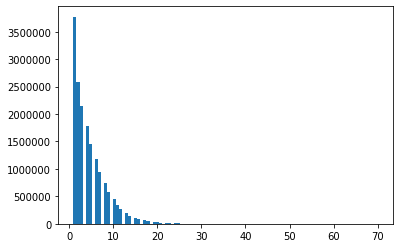

In [37]:
# plot rptr bc coverage 
plt.hist(rbcov['RPTR BCs'], bins=100)
plt.show()

In [13]:
map3.to_csv('A10_v2_1_tbcmapDEEP.csv')

In [ ]:
# def getmid(seq, pre, post):
#     # seq = the sequence to parse
#     # pre = substring that precedes piece of interest
#     # post = substring that follows piece of interest
#     # returns piece of interest
    
#     re_key = pre + "(.*)"+ post
#     poi_search = re.search(re_key, seq)
# #     print(poi_search)
#     if poi_search is None:
#         poi = "X"
#     else:
#         poi = poi_search.group(1)
    
#     return poi

# def finder(seqn, t5= "GGCTA.C", t3 = "TGAC.AGCTGAGG", 
#            abc5= "GAGGCGCGCC", abc3= "GGGCCCCTT", 
#            rbc5= "GCTCGAG", rbc3= "GGCC...CAT", 
#            reverse_comp = True): 
#     # seqn is a raw sequence from a fastq file
    
#     """This fxn was originally the tilebc_mapper workhorse, 
#     now it's written as a separate function to let tilebc_mapper be a parallelized process"""

#     #clean the line
#     seq = seqn.strip()
# #     print(seq)
    
#     #get reverse complement
#     if reverse_comp:
#         seq = reverse_complement(seq)
# #         print("RC: " + seq)
        
#     #use consensus seq to find tile, ad bc, rptr bc    
#     tile = getmid(seq, t5, t3) 
#     if tile in dtiles: # check if tiles match design file
#         des_query = 1
#     else:
#         des_query = 0
#     adBC = getmid(seq, abc5, abc3)
#     rpBC = getmid(seq, rbc5, rbc3)
    
    
#     return tile, des_query, adBC, rpBC


# def tilebc_mapper(readfile):
    
#     #readfile = file of SEQUENCES ONLY
#     # *_pre or *_post = the consensus sequences before or after each feature

#     tile_list = []
#     des_query_list = []
#     adBC_list = []
#     rpBC_list = []
    
#     with open(readfile, 'r') as fin:
#         start = time.perf_counter()
#         with concurrent.futures.ProcessPoolExecutor() as executor:
#             for t, td, a, r in executor.map(finder, fin):
#                 tile_list.append(t)
#                 des_query_list.append(td)
#                 adBC_list.append(a)
#                 rpBC_list.append(r)
                
#         finish = time.perf_counter()
#         print(f'finished in {round(finish-start, 2)} seconds')          
            
#     # make the df
    
#     tileBC_dict = {"Tiles":tile_list, "Designed": des_query_list, 
#                   "AD BCs":adBC_list, 
#                    "RPTR BCs":rpBC_list}
#     tileBC_df = pd.DataFrame.from_dict(tileBC_dict)
    
#     return tileBC_df